In [1]:
!which python env

/shared/home/sw_hdai/anaconda3/bin/python
/usr/bin/env


In [2]:
pwd

'/shared/home/sw_hdai/POSTECH_github'

In [18]:
import numpy as np
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import random
import os
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import requests
import json
import joblib
import sys 
from datetime import datetime, timedelta
from secret import get_api_key 
API_KEY = get_api_key()

In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(9)

### Load model for prediction

In [20]:
predictor = TabularPredictor.load("no_scaling_junhan_model",require_py_version_match=False)

Found 1 mismatches between original and current metadata:


### Get current tiem

In [21]:
current_time = datetime.now(pytz.timezone('Asia/Seoul'))
next_day = current_time + timedelta(days=1)
current_hour = current_time.hour
current_minute = current_time.minute

date = next_day.strftime('%Y-%m-%d')
if 9 <= current_hour < 10:
    bid_round = 1
elif 16 <= current_hour < 18:
    bid_round = 2
else:
    bid_round = 1
print("today is = ", current_time) 
print("date =", date)
print("bid_round =", bid_round)


today is =  2023-11-13 10:12:25.801527+09:00
date = 2023-11-14
bid_round = 1


In [22]:
gen_fcst = requests.get(f'https://research-api.solarkim.com/cmpt-2023/gen-forecasts/{date}/{bid_round}', headers={
                        'Authorization': f'Bearer {API_KEY}'
                    }).json()
weather_fcst = requests.get(f'https://research-api.solarkim.com/cmpt-2023/weathers-forecasts/{date}/{bid_round}', headers={
                        'Authorization': f'Bearer {API_KEY}'
                    }).json()
model_pred = pd.DataFrame(gen_fcst)

In [23]:
weather_fcst_df = pd.DataFrame(weather_fcst)
tmrw_weather = weather_fcst_df.drop(columns = 'time')
test = pd.concat([model_pred, tmrw_weather], axis=1)

test['time'] = pd.to_datetime(test['time'])
test['time'] = test['time'].dt.tz_convert(pytz.timezone('Asia/Seoul')).dt.strftime('%Y-%m-%d %H:%M:%S')
# 임시 이름(충돌 방지)
new_column_names = {'model1': '0', 'model2': '1', 'model3': '2', 'model4': '3', 'model5': '4'}
test = test.rename(columns=new_column_names)
# 컬럼 이름 변경
new_column_names = {'0': 'model0', '1': 'model1', '2': 'model2', '3': 'model3', '4': 'model4'}
test = test.rename(columns=new_column_names)

# round 열 만들기
test['round'] = bid_round - 1

# vis열을 하루동안의 vis 평균값으로 대체
# Convert 'time' to datetime and extract date part for grouping
test['date'] = pd.to_datetime(test['time']).dt.date

# Calculate the mean 'vis' for each 'round' and 'date'
vis_mean_per_round_and_date = test.groupby(['round', 'date'])['vis'].mean().reset_index()

# Merge the mean values back onto the original dataframe
test = pd.merge(
    test,
    vis_mean_per_round_and_date,
    on=['round', 'date'],
    how='left',
    suffixes=('', '_mean')
)

# Replace the 'vis' values with the mean values
test['vis'] = test['vis_mean']

# Drop the temporary columns used for the calculation
test = test.drop(columns=['date', 'vis_mean'])

# azimuth(방위각), wind_dir(풍향) 열(각도)에 대해 삼각변환 진행
test['azimuth_sin'] = np.sin(np.radians(test['azimuth']))
test['azimuth_cos'] = np.cos(np.radians(test['azimuth']))
test['wind_dir_sin'] = np.sin(np.radians(test['wind_dir']))
test['wind_dir_cos'] = np.cos(np.radians(test['wind_dir']))

# Drop the original 'azimuth' and 'wind_dir' columns
test.drop(['azimuth', 'wind_dir'], axis=1, inplace=True)

# time열을 month, day, hour로 나누고 is_utilizable이 항상 0인 시간대를 제거(0~7, 20~23)
# Split 'time' into 'month', 'day', and 'hour' columns
test['time'] = pd.to_datetime(test['time'])
test['month'] = test['time'].dt.month
test['day'] = test['time'].dt.day
test['hour'] = test['time'].dt.hour

# Remove rows where 'hour' is between 0 to 7 or 20 to 23
test = test[
    ~test['hour'].between(0, 7) &
    ~test['hour'].between(20, 23)
]

# month, day 열을 이용해서 day_of_year 열을 생성
test['day_of_year'] = test['time'].dt.dayofyear

# Drop the original 'time' column as it's no longer needed
test.drop('time', axis=1, inplace=True)

# month, day, day_of_year 열에 삼각변환 진행
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)
test['day_sin'] = np.sin(2 * np.pi * test['day'] / 31)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 31)
test['day_of_year_sin'] = np.sin(2 * np.pi * test['day_of_year'] / 365)
test['day_of_year_cos'] = np.cos(2 * np.pi * test['day_of_year'] / 365)

test[['month', 'month_sin', 'month_cos', 'day', 'day_sin', 'day_cos', 'day_of_year', 'day_of_year_sin', 'day_of_year_cos']]

# vis열 값 1개 출력
print(test['vis'].head(1))

# 피쳐 스케일링 # scaler는 train데이터셋에서 fit하고 와야됨
scaler = joblib.load('scaler/no_scaling_model_predictions.pkl')
original_feature_names = scaler.get_feature_names_out()
test[original_feature_names] = scaler.transform(test[original_feature_names])

7    16.0934
Name: vis, dtype: float64


In [24]:
predictor = TabularPredictor.load("no_scaling_junhan_model",require_py_version_match=False)
pred_y = predictor.predict(test)
pred_y = pred_y.apply(lambda x: 0 if x < 0 else x)

# hour 0~7, 20~23인 데이터값 0으로 추가
front_zeros = np.zeros(7)
end_zeros = np.zeros(5)
pred_y = np.concatenate((front_zeros, pred_y, end_zeros))
pred_y = pd.Series(pred_y, index=np.arange(24))

Found 1 mismatches between original and current metadata:


In [25]:
print(f"prediction completed : \n{pred_y}")

prediction completed : 
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      3.337164
8     20.945618
9     38.245941
10    53.587128
11    59.305489
12    55.117886
13    64.611183
14    49.721634
15    42.469139
16    19.383106
17     0.880280
18     0.000000
19     0.000000
20     0.000000
21     0.000000
22     0.000000
23     0.000000
dtype: float64


In [26]:
# import requests
# import json
# data_list = pred_y.tolist()
# amounts = data_list
# success = requests.post(f'https://research-api.solarkim.com/cmpt-2023/bids', data=json.dumps(amounts), headers={
#                             'Authorization': f'Bearer {API_KEY}'
#                         }).json()
# print("post is succeed = ", success)

### 시각화

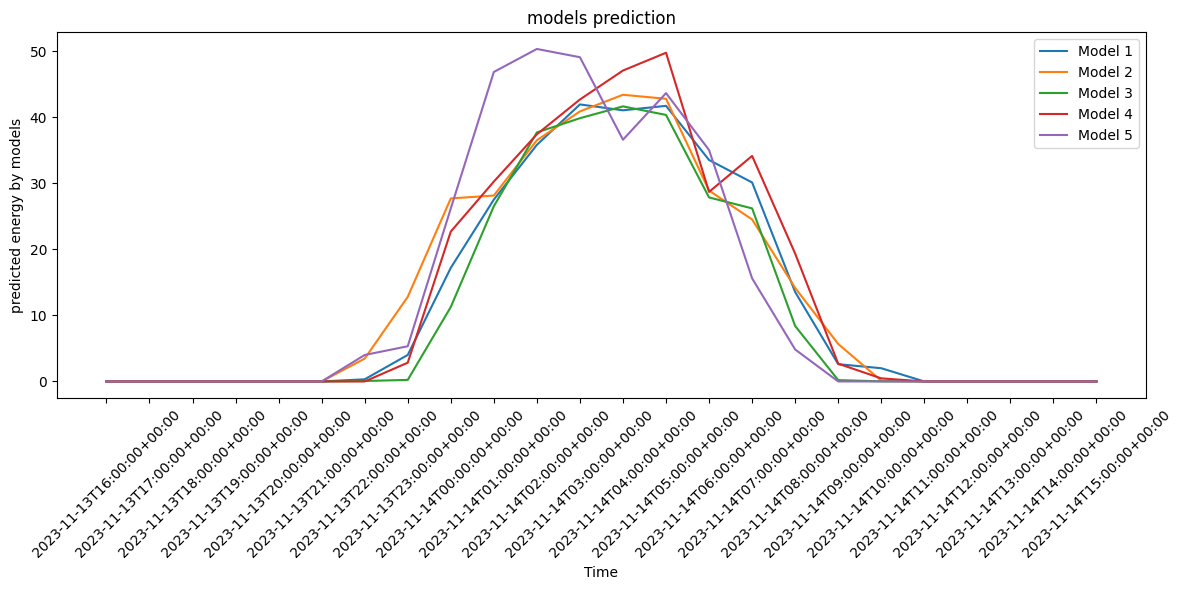

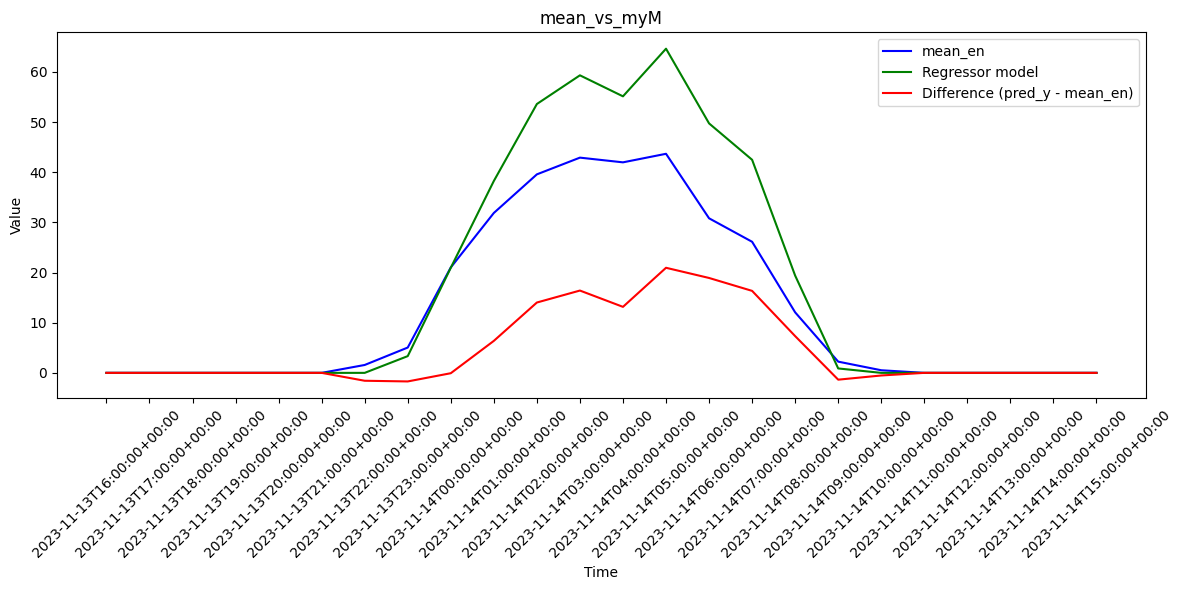

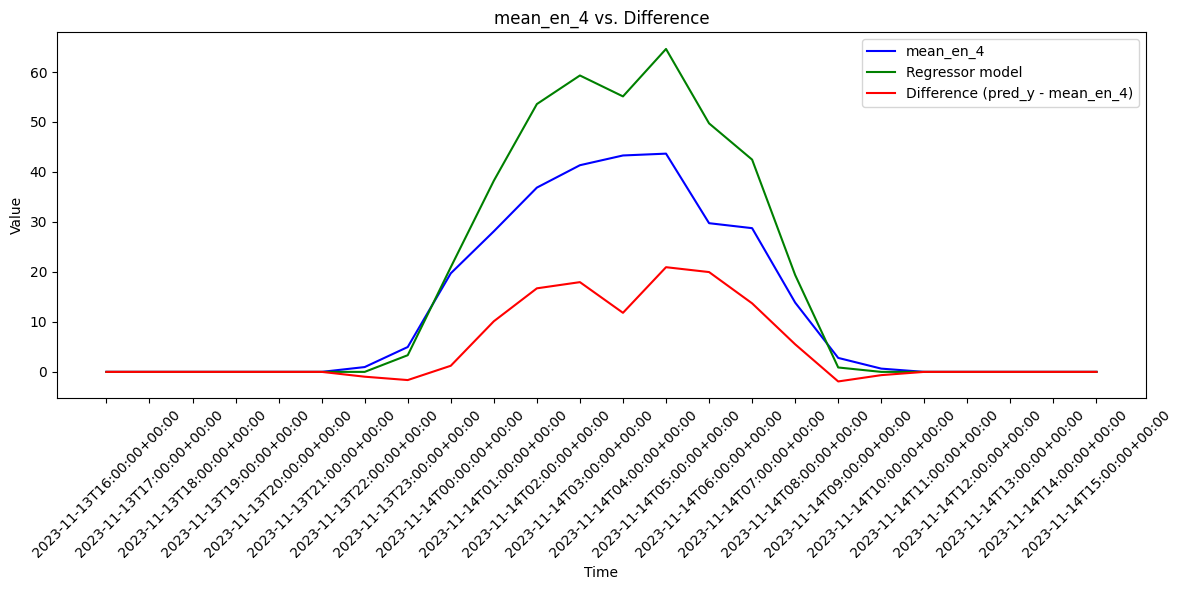

In [27]:
model1 = [entry['model1'] for entry in gen_fcst]
model2 = [entry['model2'] for entry in gen_fcst]
model3 = [entry['model3'] for entry in gen_fcst]
model4 = [entry['model4'] for entry in gen_fcst]
model5 = [entry['model5'] for entry in gen_fcst]
times = [entry['time'] for entry in gen_fcst]
plt.figure(figsize= (12,6))
plt.plot(times, model1, label = 'Model 1')
plt.plot(times, model2, label = 'Model 2')
plt.plot(times, model3, label = 'Model 3')
plt.plot(times, model4, label = 'Model 4')
plt.plot(times, model5, label = 'Model 5')

plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.ylabel('predicted energy by models')

plt.title('models prediction')
plt.legend()
plt.tight_layout()
#save img
save_dir = 'vis_result'
os.makedirs(save_dir, exist_ok=True)
file_name = f'{date}_{bid_round}_ori_pred.png'
file_path = os.path.join(save_dir, file_name)
plt.savefig(file_path)
plt.show()

model1 = pd.Series(model1)
model2 = pd.Series(model2)
model3 = pd.Series(model3)
model4 = pd.Series(model4)
model5 = pd.Series(model5)
mean_en = (model1 + model2 + model3 + model4+ model5)/5
difference = pred_y - mean_en
plt.figure(figsize=(12, 6))

# mean_en 그래프 그리기
plt.plot(times, mean_en, label='mean_en', color='blue')
plt.plot(times, pred_y, label = 'Regressor model', color='green')
# pred_y와 mean_en 차이 그래프 그리기
plt.plot(times, difference, label='Difference (pred_y - mean_en)', color='red')

plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Value')

plt.title('mean_vs_myM')
plt.legend()
plt.tight_layout()
file_name = f'{date}_{bid_round}_mean5_vs_myM.png'
file_path = os.path.join(save_dir, file_name)
plt.savefig(file_path)
plt.show()
# 4개 모델의 평균과 비교하는 그래프
mean_en_4 = (model1 + model2 + model3 + model4)/4

difference = pred_y - mean_en_4
plt.figure(figsize=(12, 6))

# mean_en 그래프 그리기
plt.plot(times, mean_en_4, label='mean_en_4', color='blue')
plt.plot(times, pred_y, label = 'Regressor model', color='green')
# pred_y와 mean_en 차이 그래프 그리기
plt.plot(times, difference, label='Difference (pred_y - mean_en_4)', color='red')

plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Value')

plt.title('mean_en_4 vs. Difference')
plt.legend()
plt.tight_layout()
#save img
file_name = f'{date}_{bid_round}_mean4_vs_myM.png'
file_path = os.path.join(save_dir, file_name)
plt.savefig(file_path)
plt.show()



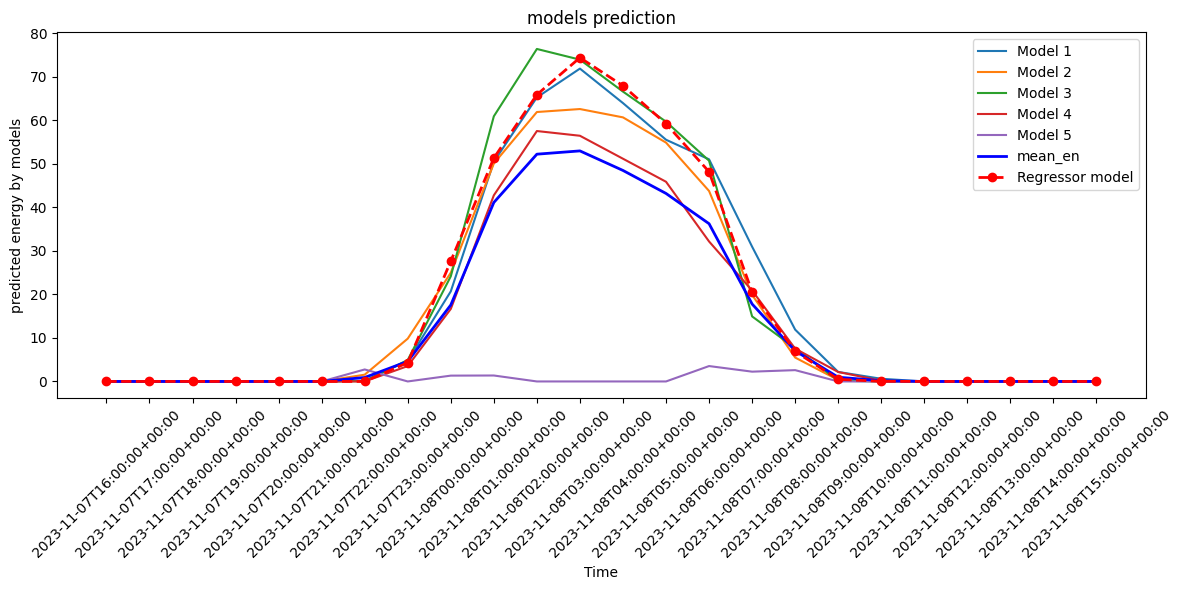

In [33]:
model1 = [entry['model1'] for entry in gen_fcst]
model2 = [entry['model2'] for entry in gen_fcst]
model3 = [entry['model3'] for entry in gen_fcst]
model4 = [entry['model4'] for entry in gen_fcst]
model5 = [entry['model5'] for entry in gen_fcst]
times = [entry['time'] for entry in gen_fcst]
m1 = pd.Series(model1)
m2 = pd.Series(model2)
m3 = pd.Series(model3)
m4 = pd.Series(model4)
m5 = pd.Series(model5)
mean_en = (m1 + m2 + m3 + m4+ m5)/5

plt.figure(figsize= (12,6))

plt.plot(times, model1, label = 'Model 1')
plt.plot(times, model2, label = 'Model 2')
plt.plot(times, model3, label = 'Model 3')
plt.plot(times, model4, label = 'Model 4')
plt.plot(times, model5, label = 'Model 5')
plt.plot(times, mean_en, label='mean_en', color='blue', linewidth=2)
plt.plot(times, pred_y, label = 'Regressor model', color='red', linewidth=2, linestyle='--', marker='o', )

plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.ylabel('predicted energy by models')

plt.title('models prediction')
plt.legend()
plt.tight_layout()
file_name = f'{date}_{bid_round}_all.png'
file_path = os.path.join(save_dir, file_name)
plt.savefig(file_path)
plt.show()